# Stoneburner, Kurt
- ## DSC 650 - Assignment 12


Importing Pillow images into Numpy
https://www.pluralsight.com/guides/importing-image-data-into-numpy-arrays

Pillow Resize Images: https://pythonexamples.org/python-pillow-resize-image/

Celeb A Dataset: http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html

In [1]:
import os
import sys
# //*** Imports and Load Data
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pathlib import Path
import time

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

#//*** Use the whole window in the IPYNB editor
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

#//*** Clear the output display, helpful for content that updates
from IPython.display import clear_output


#//*** Maximize columns and rows displayed by pandas
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', None)

import PIL
from PIL import Image
#//*** Get Working Directory
current_dir = Path(os.getcwd()).absolute()

#//*** Build Image Directory
base_image_dir = current_dir.parents[2].joinpath("img_align_celeba")



Tensorflow Datasets: https://www.tensorflow.org/datasets/overview

Resizing:  100000 / 100000


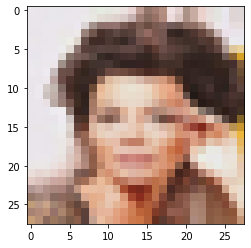

(28, 28, 3)
90000
90000 10000


In [2]:

#//**** 128x128 attributes
attribs = {
    'size' : (128,128),
    'keras_dims' : (128,128,3),

    'sample_size' : 1005,
    'test_split' : .5
}

#//**** 28x28 attributes
attribs = {
    'size' : (28,28),
    'keras_dims' : (28,28,3),

    'sample_size' : 100000,
    'test_split' : .1
}




x_train = []




counter = 1
for filename in os.listdir(base_image_dir)[:attribs['sample_size']]:
    clear_output(wait=True)
    
    
    print("Resizing: ", counter,"/",attribs['sample_size'])

    #//*** File does not exist. Open original and resize

    #//*** Open Pillow Image Object
    image = Image.open(base_image_dir.joinpath(filename))

    #//*** Resize Image
    image = image.resize(attribs['size'])

    #//*** Save Image
   # image.save(resize_dir.joinpath(filename))

    #//*** Add image to training set
    x_train.append( np.asarray(image) )

        
    counter += 1

    
    #//*** Display Images
    #plt.imshow(image.resize(attribs['dims']))
    #plt.show()
    #print(type(data))
    #print(data.shape)

#//*** Display a sample image
plt.imshow(Image.fromarray(x_train[0])   )
plt.show()

print(x_train[0].shape)

#//*** Index to split for test train
split_index = len(x_train) - int(len(x_train)*attribs['test_split'])
print(split_index)

x_test = x_train[split_index:]

x_train = x_train[:split_index]

print(len(x_train),len(x_test))

In [3]:
#//*** Index to split for test train
split_index = len(x_train) - int(len(x_train)*attribs['test_split'])
print(split_index)

x_test = x_train[split_index:]

x_train = x_train[:split_index]

print(len(x_train),len(x_test))

81000
81000 9000


**Variational Autoencoder network**

In [4]:
latent_dim = 3

encoder_inputs = keras.Input(shape=(attribs['keras_dims']))
x = layers.Conv2D(32, 3, activation="relu", strides=2, padding="same")(encoder_inputs)
x = layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Flatten()(x)
x = layers.Dense(16, activation="relu")(x)
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var], name="encoder")

encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 28, 28, 3)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 14, 14, 32)   896         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 7, 7, 64)     18496       conv2d[0][0]                     
__________________________________________________________________________________________________
flatten (Flatten)               (None, 3136)         0           conv2d_1[0][0]                   
____________________________________________________________________________________________

**Latent-Sapce-Sampling Layer**

In [5]:
class Sampler(layers.Layer):
    def call(self, z_mean, z_log_var):
        batch_size = tf.shape(z_mean)[0]
        z_size = tf.shape(z_mean)[1]
        epsilon = tf.random.normal(shape=(batch_size, z_size))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon



**Variational decoder network, mapping latent space points to images**

In [6]:
#//*** Dimensional Value. Convenience value for resizing the output layer to match the input size.
dv = 7
latent_inputs = keras.Input(shape=(latent_dim,))
x = layers.Dense(dv * dv * 64, activation="relu")(latent_inputs)
x = layers.Reshape((dv, dv, 64))(x)
x = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)
decoder_outputs = layers.Conv2D(3, 3, activation="sigmoid", padding="same")(x)
decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")

decoder.summary()

Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 3)]               0         
_________________________________________________________________
dense_1 (Dense)              (None, 3136)              12544     
_________________________________________________________________
reshape (Reshape)            (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 14, 14, 64)        36928     
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 28, 28, 32)        18464     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 3)         867       
Total params: 68,803
Trainable params: 68,803
Non-trainable params: 0
_______________________________________________________

**Variational Autoencoder with custom train_step()**

In [7]:
class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.sampler = Sampler()
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss")
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [self.total_loss_tracker,
                self.reconstruction_loss_tracker,
                self.kl_loss_tracker]

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var = self.encoder(data)
            z = self.sampler(z_mean, z_log_var)
            reconstruction = decoder(z)
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(
                    keras.losses.binary_crossentropy(data, reconstruction),
                    axis=(1, 2)
                )
            )
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            total_loss = reconstruction_loss + tf.reduce_mean(kl_loss)
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "total_loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

**Training the Variational Auto Encoder**

(90000, 28, 28, 3)
Epochs: 1
704/704 [==============================] - 82s 117ms/step - total_loss: 2193.1199 - reconstruction_loss: 2187.8176 - kl_loss: 5.3011


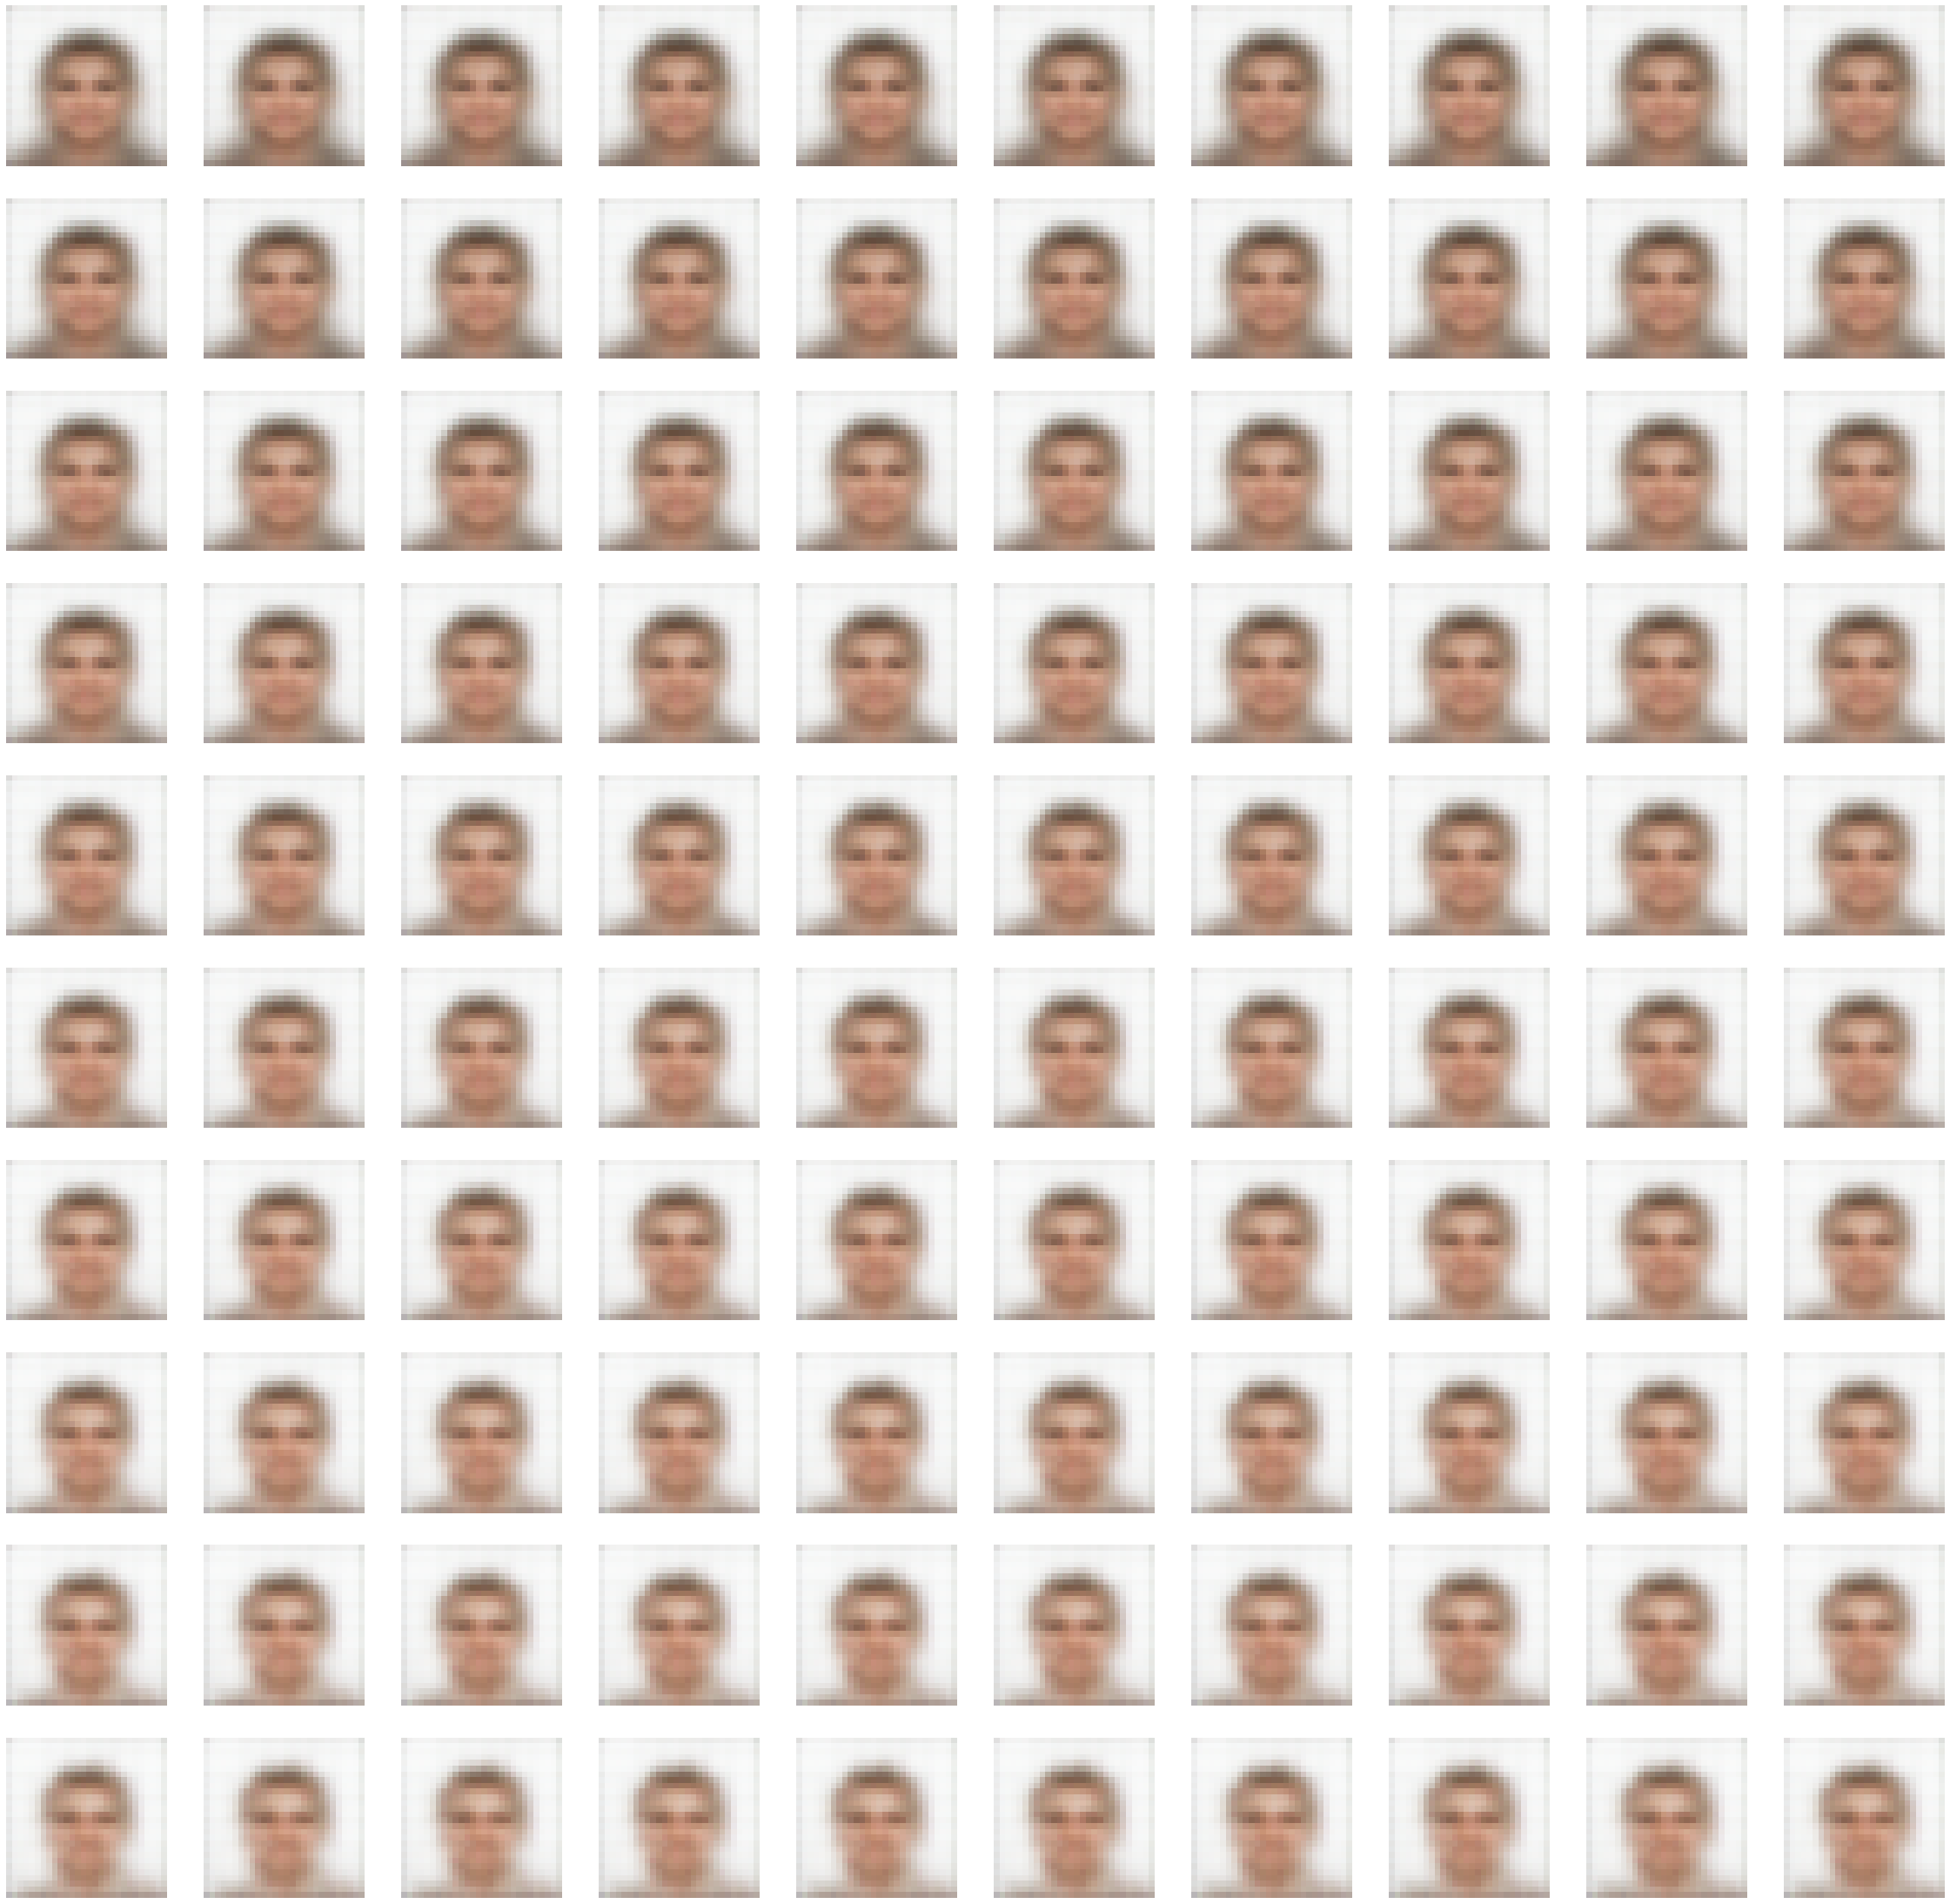

In [8]:
mnist_digits = np.concatenate([x_train, x_test], axis=0).astype("float32") / 255
#mnist_digits = np.expand_dims(mnist_digits, -1).astype("float32") / 255



print(mnist_digits.shape)
#print(mnist_digits[0])

for epoch in  [1,]:
    
    print("==============")
    print("Epochs:",epoch)
    print("==============")
    vae = VAE(encoder, decoder)
    vae.compile(optimizer=keras.optimizers.Adam(), run_eagerly=True)
    vae.fit(mnist_digits, epochs=epoch, verbose=1, batch_size=128)


    import matplotlib.pyplot as plt

    n = 10
    digit_size = 128
    figure = np.zeros((digit_size * n, digit_size * n))

    grid_x = np.linspace(-1, 1, n)
    grid_y = np.linspace(-1, 1, n)[::-1]
    plt.figure(figsize=(40,40))
    count=1
    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = np.array([[xi, yi,yi]])
            x_decoded = vae.decoder.predict(z_sample)[0]
            raw_img = (x_decoded*255).astype(np.uint8)
            plt.subplot(n,n,count)
            plt.imshow(Image.fromarray(raw_img)   )
            plt.axis("off")


            count+=1

    plt.show()

**Sampling a grid of images from the 2D latent space**

Resizing:  10000 / 10000


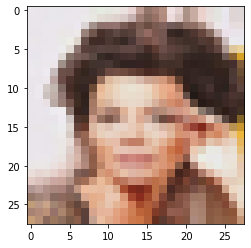

(28, 28, 3)
9000
9000 1000


In [10]:

#//**** 128x128 attributes
attribs = {
    'size' : (128,128),
    'keras_dims' : (128,128,3),

    'sample_size' : 1005,
    'test_split' : .5
}

#//**** 28x28 attributes
attribs = {
    'size' : (28,28),
    'keras_dims' : (28,28,3),

    'sample_size' : 10000,
    'test_split' : .1
}




x_train = []




counter = 1
for filename in os.listdir(base_image_dir)[:attribs['sample_size']]:
    clear_output(wait=True)
    
    
    print("Resizing: ", counter,"/",attribs['sample_size'])

    #//*** File does not exist. Open original and resize

    #//*** Open Pillow Image Object
    image = Image.open(base_image_dir.joinpath(filename))

    #//*** Resize Image
    image = image.resize(attribs['size'])

    #//*** Save Image
   # image.save(resize_dir.joinpath(filename))

    #//*** Add image to training set
    x_train.append( np.asarray(image) )

        
    counter += 1

    
    #//*** Display Images
    #plt.imshow(image.resize(attribs['dims']))
    #plt.show()
    #print(type(data))
    #print(data.shape)

#//*** Display a sample image
plt.imshow(Image.fromarray(x_train[0])   )
plt.show()

print(x_train[0].shape)

#//*** Index to split for test train
split_index = len(x_train) - int(len(x_train)*attribs['test_split'])
print(split_index)

x_test = x_train[split_index:]

x_train = x_train[:split_index]

print(len(x_train),len(x_test))

(10000, 28, 28, 3)
Epochs: 1
79/79 [==============================] - 9s 116ms/step - total_loss: 2122.3503 - reconstruction_loss: 2116.5896 - kl_loss: 5.7435


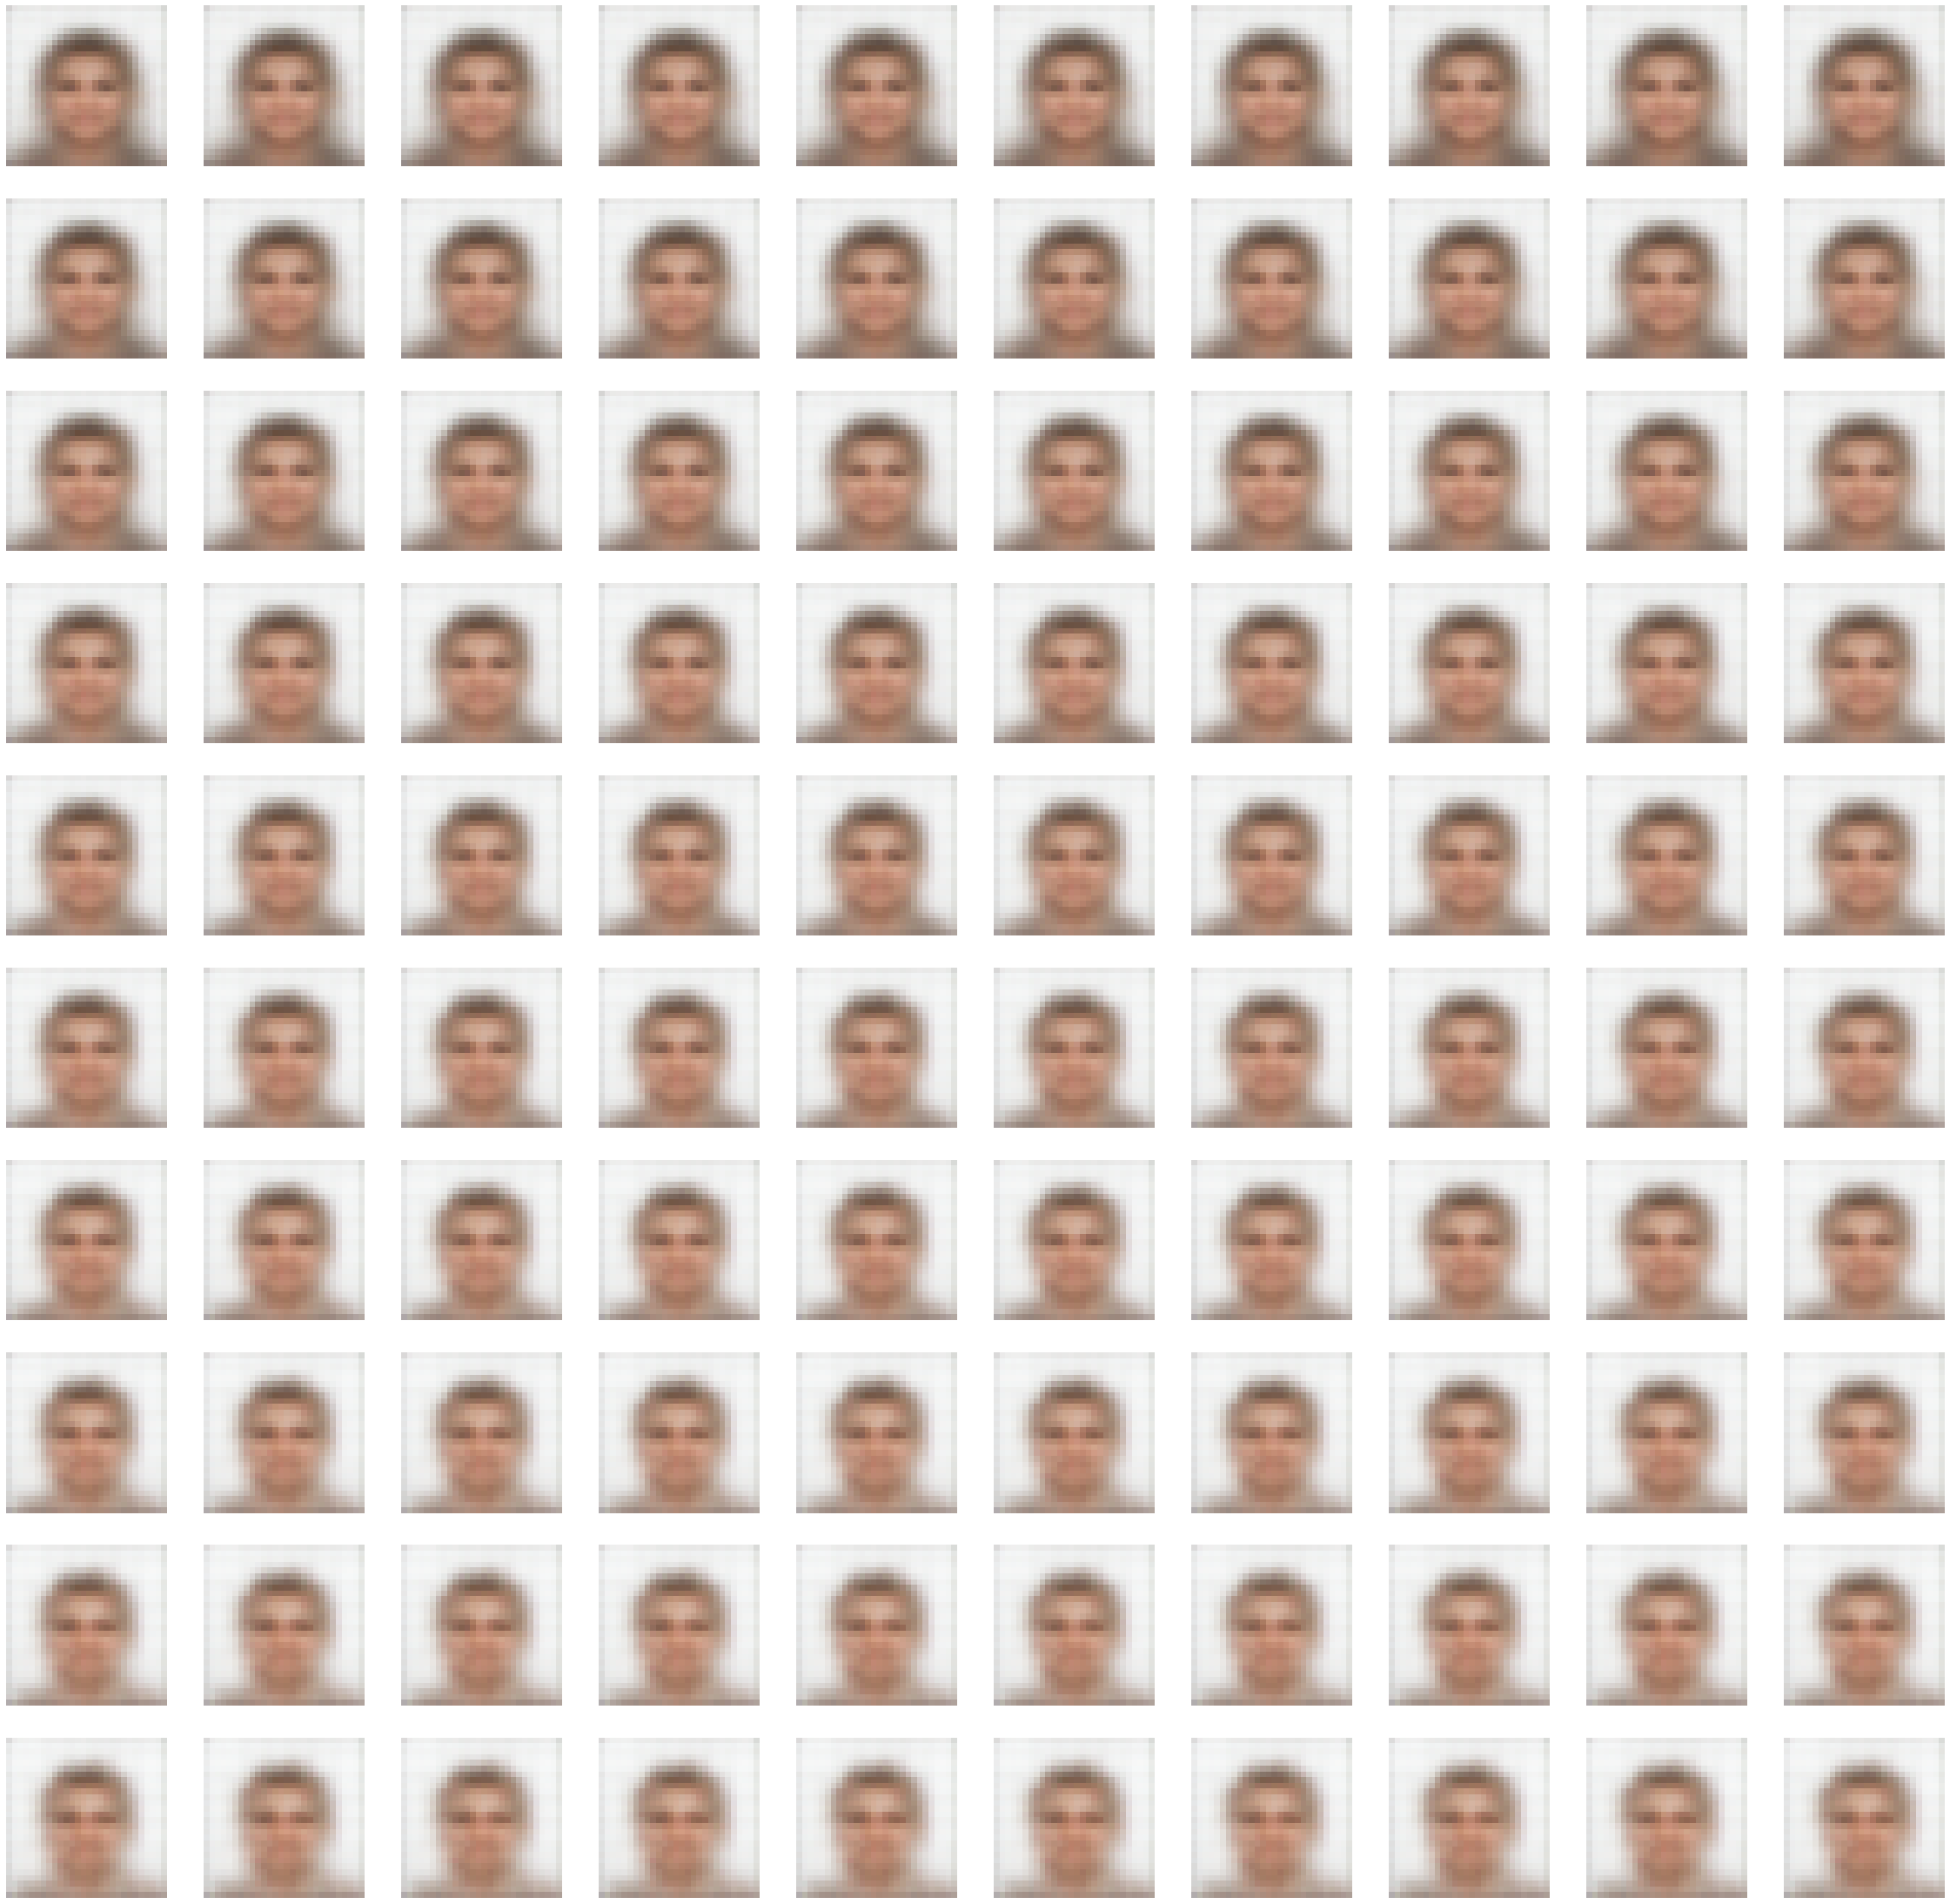

In [11]:
mnist_digits = np.concatenate([x_train, x_test], axis=0).astype("float32") / 255
#mnist_digits = np.expand_dims(mnist_digits, -1).astype("float32") / 255



print(mnist_digits.shape)
#print(mnist_digits[0])

for epoch in  [1,]:
    
    print("==============")
    print("Epochs:",epoch)
    print("==============")
    vae = VAE(encoder, decoder)
    vae.compile(optimizer=keras.optimizers.Adam(), run_eagerly=True)
    vae.fit(mnist_digits, epochs=epoch, verbose=1, batch_size=128)


    import matplotlib.pyplot as plt

    n = 10
    digit_size = 128
    figure = np.zeros((digit_size * n, digit_size * n))

    grid_x = np.linspace(-1, 1, n)
    grid_y = np.linspace(-1, 1, n)[::-1]
    plt.figure(figsize=(40,40))
    count=1
    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = np.array([[xi, yi,yi]])
            x_decoded = vae.decoder.predict(z_sample)[0]
            raw_img = (x_decoded*255).astype(np.uint8)
            plt.subplot(n,n,count)
            plt.imshow(Image.fromarray(raw_img)   )
            plt.axis("off")


            count+=1

    plt.show()

In [9]:
# //*** CODE HERE